# Demo LoFTR-DS on a single pair of images

This notebook shows how to use the loftr matcher with default config(dual-softmax) and the pretrained weights.

In [1]:
import os
os.chdir("..")
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

## Indoor Example

In [6]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [7]:
# Load example images
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

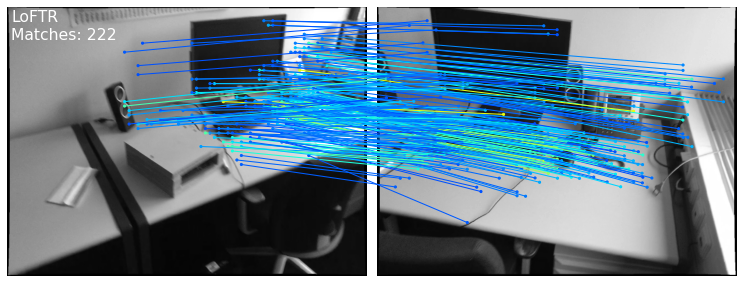

In [8]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text)

## Outdoor Example

In [9]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [10]:
# Load example images
img0_pth = "assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

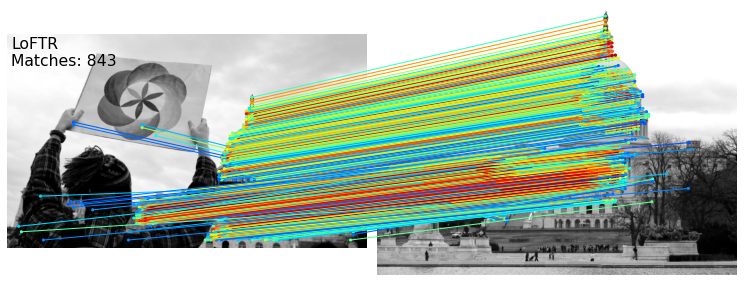

In [11]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text)

# Westlake Day-Night

In [18]:
import sys
sys.path.append('/root/dev/LoFTR')
from pathlib import Path

import pyheif
import pydegensac
from PIL import Image

In [17]:
def read_image(pth):
    if isinstance(pth, Path):
        suffix = pth.suffix
    else:
        suffix = Path(pth).suffix
    
    if suffix.lower() == '.heic':
        heif_file = pyheif.read(pth)
        image = Image.frombytes(
            heif_file.mode, 
            heif_file.size, 
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride)
        image = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)
    else:
        image = cv2.imread(pth, cv2.IMREAD_GRAYSCALE)
    return image

In [26]:
def geometric_verification(kpts0, kpts1,
                           px_thr=1.0, conf=0.99999, max_iters=10000,
                           min_candidates=10):
    if len(kpts0) < min_candidates:
        return None
    
    F, mask = pydegensac.findFundamentalMatrix(kpts0,
                                               kpts1,
                                               px_th=px_thr,
                                               conf=conf,
                                               max_iters=max_iters)
    mask = mask.astype(bool)
    return mask

def extract_inliers(kpts0, kpts1, mconfs, mask):
    return tuple(map(lambda x: x[mask], [kpts0, kpts1, mconfs]))

In [27]:
WEST_LAKE_ROOT = Path('assets/westlake')
pairs = [('IMG_8402.HEIC', 'IMG_8688.HEIC')]


In [9]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [28]:
del batch
torch.cuda.empty_cache()

In [29]:
# Load example images
INLIER_ONLY = True

p_id = 0
img0_pth = str(WEST_LAKE_ROOT / pairs[p_id][0])
img1_pth = str(WEST_LAKE_ROOT / pairs[p_id][1])

img0_raw = read_image(img0_pth)
img1_raw = read_image(img1_pth)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//32*8, img0_raw.shape[0]//32*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//32*8, img1_raw.shape[0]//32*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

if INLIER_ONLY:
    mask = geometric_verification(mkpts0, mkpts1)
    mkpts0, mkpts1, mconf = extract_inliers(mkpts0, mkpts1, mconf, mask)
    

In [31]:
mkpts0.shape, mkpts1.shape, mconf.shape

((934, 2), (934, 2), (934,))

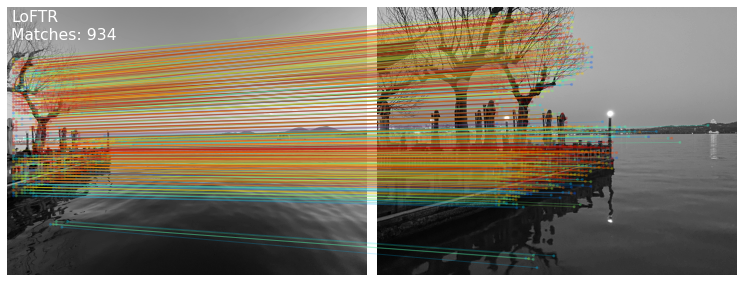

In [32]:
# Draw
alpha=0.2
color = cm.jet(mconf)
color[:, -1] *= alpha
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text)